# ECBM E4040 - Assignment 2- Task 5: Kaggle Open-ended Competition

Kaggle is a platform for predictive modelling and analytics competitions in which companies and researchers post data and statisticians and data miners compete to produce the best models for predicting and describing the data.

If you don't have a Kaggle account, feel free to join at [www.kaggle.com](https://www.kaggle.com). To let the TAs do the grading more conveniently, please use Lionmail to join Kaggle and use UNI as your username.

Visit the website for this competition to join: 
[https://www.kaggle.com/t/8dd419892b1c49a3afb0cea385a7e677](https://www.kaggle.com/t/8dd419892b1c49a3afb0cea385a7e677)

Details about this in-class competition is shown on the website above. Please read carefully.

<span style="color:red">__TODO__:</span>
1. Train a custom model for the bottle dataset classification problem. You are free to use any methods taught in the class or found by yourself on the Internet (ALWAYS provide reference to the source). General training methods include:
    * Dropout
    * Batch normalization
    * Early stopping
    * l1-norm & l2-norm penalization
2. You'll be given the test set to generate your predictions (70% public + 30% private, but you don't know which ones are public/private). Achieve 70% accuracy on the public test set. The accuracy will be shown on the public leaderboard once you submit your prediction .csv file. 
3. (A) Report your results on the Kaggle, for comparison with other students' optimization results (you should do this several times). (C) Save your best model, using BitBucket, at the same time when you (B) submit the homework files into Courseworks. See instructions below. 

__Hint__: You can start from what you implemented in task 4. Another classic classification model named 'VGG16' can also be easily implemented.

## HW Submission Details:
There are three components to reporting the results of this task: 

**(A) Submission (possible several) of the .csv prediction file throught the Kaggle platform;**. You should start doing this VARY early, so that students can compare their work as they are making progress with model optimization.

**(B) Editing and submitting the content of this Jupyter notebook, through Courseworks; **
(i) The code for your CNN model and for the training function. The code should be stored in __./ecbm4040/neuralnets/kaggle.py__;
(ii) Print out your training process and accuracy __within this notebook__;

**(C) Submitting your best CNN model through instructor-owned private BitBucket repo.**

**Description of (C):** 
For this task, you will be utilizing bitbucket to save your model for submission. Bitbucket provides Git code managment. For those who are not familiar with git operations, please check [Learn Git with Bitbucket Cloud](https://www.atlassian.com/git/tutorials/learn-git-with-bitbucket-cloud) as reference.
**TAs will create a private Bitbucket repository for each student, with the write access. This repo will be owned by the instructors. Make sure to properly submit your model to that exact repository (submissions to your own private repository will not count)** Students need to populate the following file to provide instructors with bitbucket account information: https://docs.google.com/spreadsheets/d/1_7cZjyr34I2y-AD_0N5UaJ3ZnqdhYcvrdoTsYvOSd-g/edit#gid=0.

<span style="color:red">__Submission content:__ :</span>
(i) Upload your best model with all the data output (for example, __MODEL.data-00000-of-00001, MODEL.meta, MODEL.index__) into the  BitBucket. Store your model in the folder named "__KaggleModel__" within the BitBucket repository. 
Remember to delete any intermediate results, **we only want your best model. Do not upload any data files**. The instructors will rerun the uploaded best model and verify against the score which you reported on the Kaggle.



In [2]:
from PIL import Image
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
import tensorflow as tf

# Import modules
from __future__ import print_function
import numpy as np
from ecbm4040.cifar_utils import load_data
import matplotlib.pyplot as plt

# im = im.resize((96,96),Image.ANTIALIAS)
# np_im = np.array(im)

In [ ]:
import cv2
import pickle
import numpy as np


resizeTo=96
extension = ".png"

path_to_image_folder = "train_128/"#Wherever you have your images
num_train_samples_per_class = 3000 #Ideally you could count the elements in the folder
num_classes = 5
train_img_names = []
train_labels = []

for _class in range(num_classes):
    path = path_to_image_folder + str(_class) + "/"
    train_img_names += [path + str(idx) + extension for idx in 
                        range(_class*num_train_samples_per_class, (_class+1)*num_train_samples_per_class)]
    train_labels += [str(_class)]*num_train_samples_per_class
train_labels=np.asarray(train_labels)
train_images = []
for img_name in train_img_names:
#     im = cv2.imread(img_name)
    im = Image.open(img_name)
    im = im.resize((resizeTo,resizeTo),Image.ANTIALIAS)
    train_images.append(np.array(im))
    
xTrain = np.asarray(train_images)

path_to_image_folder = "test_128/"#Wherever you have your images
num_test_samples = 3500 #Ideally you could count the elements in the folder
test_img_names = [path_to_image_folder + str(idx) + extension for idx in range(num_test_samples)]

test_images = []
for img_name in test_img_names:
#     im = cv2.imread(img_name)
    im = Image.open(img_name)
    im = im.resize((resizeTo,resizeTo),Image.ANTIALIAS)
    test_images.append(np.array(im))
    
xTest = np.asarray(test_images)

pd.to_pickle(xTrain, "xTrain"+str(resizeTo))
pd.to_pickle(xTest, "xTest"+str(resizeTo))
pd.to_pickle(train_labels, "train_labels")

In [3]:
resizeTo=64
xTrain=pd.read_pickle('xTrain'+str(resizeTo))
xTest=pd.read_pickle('xTest'+str(resizeTo))
train_labels=pd.read_pickle('train_labels')
print(xTrain.shape)
print(xTest.shape)


(15000, 64, 64, 3)
(3500, 64, 64, 3)


In [4]:
# Load the raw CIFAR-10 data.
# X_train, y_train = load_data(mode='train')

# Data organizations:
# Train data: 49000 samples from original train set: 1~49000
# Validation data: 1000 samples from original train set: 49000~50000

s = np.arange(xTrain.shape[0])
np.random.shuffle(s)
xTrainS=xTrain[s]
train_labelsS=train_labels[s]
# print(xTrain.shape)
# print(train_labelsS.shape)

num_training = 14000
num_validation = 1000

X_val = xTrainS[-num_validation:, :]
y_val = np.asarray(train_labelsS[-num_validation:])

X_train = xTrainS[:num_training, :]
y_train = np.asarray(train_labelsS[:num_training])

# Preprocessing: subtract the mean value across every dimension for training data, and reshape it to be RGB size
mean_image = np.mean(X_train, axis=0)
X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image

X_train = X_train/255
X_val = X_val/255

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)

Train data shape:  (14000, 64, 64, 3)
Train labels shape:  (14000,)
Validation data shape:  (1000, 64, 64, 3)
Validation labels shape:  (1000,)


## Train your model here

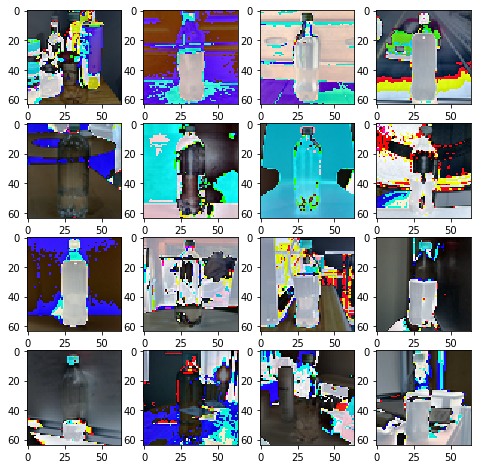

In [5]:
from ecbm4040.image_generator import ImageGenerator
ig=ImageGenerator(X_val, y_val)
ig.show()

In [6]:
# YOUR CODE HERE
from ecbm4040.neuralnets.kaggle import my_training_task
from ecbm4040.neuralnets.kaggle import my_training
from ecbm4040.neuralnets.kaggle import my_LeNet_final
# from ecbm4040.neuralnets.cnn import my_training

tf.reset_default_graph()

# my_training(X_train, y_train, X_val, y_val)
# my_training(X_train, y_train, X_val, y_val, ...)
# my_training(X_train, y_train, X_val, y_val, ...)

my_training_task(X_train, y_train, X_val, y_val, 
         conv_featmap=[64, 64],
         fc_units=[84],
         conv_kernel_size=[5, 5],
         pooling_size=[2, 2],
         l2_norm=0.01,
         seed=235,
         learning_rate=1e-2,
         epoch=20,
         batch_size=245,
         verbose=False,
         pre_trained_model="lenet_1509930360", modelName=my_LeNet_final)

Building my LeNet. Parameters: 
conv_featmap=[64, 64]
fc_units=[84]
conv_kernel_size=[5, 5]
pooling_size=[2, 2]
l2_norm=0.01
seed=235
learning_rate=0.01
number of batches for training: 57
Load the model from: lenet_1509930360
INFO:tensorflow:Restoring parameters from model/lenet_1509930360
epoch 1 
epoch 2 
Best validation accuracy! iteration:100 accuracy: 84.5%
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Traning ends. The best valid accuracy is 84.5. Model named lenet_1509942315.


## Save your best model

In [7]:
tf.reset_default_graph()
with tf.Session() as sess:
    saver=tf.train.import_meta_graph('model/lenet_1509942315.meta')
    saver.restore(sess, tf.train.latest_checkpoint('model/'))
    graph=tf.get_default_graph()
    
    tf_input=graph.get_operations()[0].name+':0'
    x=graph.get_tensor_by_name(tf_input)
    
    tf_output="fc_layer_1/Add:0"
    y=graph.get_tensor_by_name(tf_output)
    
    ypred=sess.run(y, feed_dict={x:xTest})   
    print(ypred.shape)
    
#     predic= graph.get_tensor_by_name("predict/ArgMax:0")
    
#     outs=[]
#     for i in range(X_test.shape[0]):
#         outs.append(sess.run(predict, feed_dict={x:X_test[i:i+1]})[0])

INFO:tensorflow:Restoring parameters from model/lenet_1509942315
(3500, 5)


In [8]:
yp=np.argmax(ypred, axis=1)

## Generate .csv file for Kaggle

In [9]:
# The following code snippet can be used to generate your prediction .csv file.

import csv
with open('predicted.csv','w') as csvfile:
    fieldnames = ['Id','label']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()    
    for index,l in enumerate(yp):
        filename = str(index)+'.png'
        label = str(l)
        writer.writerow({'Id': filename, 'label': label})